In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import timm
import torch
from albumentations import (
    Compose,
    Normalize,
    ShiftScaleRotate,
    RandomBrightnessContrast,
    MotionBlur,
    CLAHE,
    HorizontalFlip
)
from copy import deepcopy
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

### Constants

In [2]:
MODEL_NAME = 'multilabel_efnb4_v1_cls'
dataset_path = "/home/jupyter/vinbigdata-chest-xray-resized-png-256x256"
model_path = "/home/jupyter/vinbigdata-chest-xray-resized-png-256x256/save_models"
class_weights_path = "/home/jupyter/vinbigdata-chest-xray-resized-png-256x256/class_weights.npy"

train_csv_path = os.path.join(dataset_path, 'vindrcxr_train.csv')
test_csv_path = os.path.join(dataset_path, 'vindrcxr_test.csv')
train_image_path = os.path.join(dataset_path, 'train')
test_image_path = os.path.join(dataset_path, 'test')
save_path = os.path.join(model_path, '')

print(train_image_path)
print(test_image_path)

/home/jupyter/vinbigdata-chest-xray-resized-png-256x256/train
/home/jupyter/vinbigdata-chest-xray-resized-png-256x256/test


In [5]:
bs = 2
lr = 1e-3
N_EPOCHS = 10
NUM_CLASSES = 15
N_TEST = 3000

### Dataset Object

In [4]:
### Code from https://github.com/Scu-sen/VinBigData-Chest-X-ray-Abnormalities-Detection

class Dataset(Dataset):
    
    def __init__(self, df, image_path, transform=None):
        self.df = df
        self.image_path = image_path
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        labels = torch.from_numpy(
            self.df.loc[idx,np.arange(0, NUM_CLASSES).astype(str).tolist()].values.astype(float)
        ).float()

        img = cv2.imread(
            self.image_path + '/' + str(self.df.image_id[idx]) + '.png'
        )
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(image=img)['image']
        img = torch.from_numpy(img.transpose((2, 0, 1))).float()
            
        return img, labels

### Model Evaluation Utility

In [6]:
def eval_model(model, data_loader):
    """
    Test the model on the validation set
    
    Parameters:
        model (torch.nn.Module): The model to be trained/validated.
        data_loader (torch.utils.data.DataLoader): Dataloader object for training/validation.
        
    Return: 
        (preds_list, targets_list): list of model predicted scores, labels
    """
    model.eval()
    
    running_loss = 0.0
    running_n = 0
    avg_loss = 0.0
    preds_list, targets_list = [], []
    
    with torch.no_grad():
        tk = tqdm(data_loader, total=len(data_loader), position=0, leave=True)
        
        for idx, (imgs, labels) in enumerate(tk):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            
            preds = torch.sigmoid(output).detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
         
            preds_list.append(preds)
            targets_list.append(labels.round().astype(int))
    preds_list = np.concatenate(preds_list,axis=0)
    return preds_list, targets_list

In [7]:
test = pd.read_csv(test_csv_path)
test_transform = Compose([
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)
])

### Model Inference on Test Set

In [ ]:
preds = np.zeros((N_TEST, NUM_CLASSES))
for class_id in range(NUM_CLASSES):
    valset = Dataset(
        test,
        image_path=test_image_path,
        transform=test_transform
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=bs, shuffle=False, num_workers=1
    )

    model = timm.create_model('tf_efficientnet_b4_ns',pretrained=True,num_classes=15).cuda()
    # Use the per-class model to make predictions for the corresponding class.
    model.load_state_dict(torch.load(os.path.join(model_path, f'{MODEL_NAME}{class_id}_weighted.pth'))['weight'])
    preds_list, targets_list = eval_model(model, val_loader)
    preds[:,class_id] = preds_list[:,class_id]

In [26]:
df_preds = pd.DataFrame(preds, columns=np.arange(0,15)).assign(image_id = test['image_id'])

In [27]:
# Save Model Predictions to CSV.
df_preds.to_csv(save_path+f'multilabel_efnb4_weighted_preds.csv', index=False)

### Load Predictions

In [8]:
df_preds = pd.read_csv(save_path+f'multilabel_efnb4_weighted_preds.csv')
df_preds.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,image_id
0,0.614671,0.903516,0.352075,0.362501,0.757495,0.875485,0.500190,0.979035,0.406775,0.841686,0.998468,0.829903,0.985413,0.880301,0.026213,e0dc2e79105ad93532484e956ef8a71a
1,0.503556,0.439617,0.397912,0.260750,0.801899,0.895951,0.879918,0.975353,0.335144,0.566168,0.996670,0.813587,0.584750,0.914139,0.077698,0aed23e64ebdea798486056b4f174424
2,0.001261,0.457572,0.069907,0.000097,0.034834,0.284097,0.262808,0.144129,0.117917,0.074215,0.110829,0.129262,0.100847,0.444714,0.980695,aa15cfcfca7605465ca0513902738b95
3,0.541474,0.118359,0.826022,0.636701,0.682221,0.976642,0.956570,0.927272,0.830182,0.750586,0.231962,0.554249,0.144741,0.864995,0.069336,665c4a6d2693dc0286d65ab479c9b169
4,0.952218,0.561251,0.560161,0.987845,0.014374,0.472018,0.110139,0.816455,0.387120,0.667929,0.081193,0.273185,0.029180,0.445197,0.057850,42da2c134b53cb5594774d3d29faac59


In [9]:
preds = df_preds.drop(['image_id'], axis=1).to_numpy()

### Compute Metrics

In [10]:
def get_per_class_metrics(metric_fn, targets_list, preds_list, class_weights=None):
    targets_list = targets_list.T
    preds_list = preds_list.T
    per_class_metrics = np.array([metric_fn(i,j) if len(set(i)) > 1 else np.nan for i,j in zip(targets_list, preds_list)])
    
    if class_weights is None:
        overall_metric = np.nanmean(per_class_metrics)
    else:
        overall_metric = np.nansum(class_weights * per_class_metrics)/np.nansum(class_weights)
    return overall_metric, per_class_metrics

In [11]:
class_weights = np.load(class_weights_path)
class_id_list = list(map(lambda x : str(x), list(range(15))))
targets = test[class_id_list].to_numpy() # np.concatenate(targets_list, axis=0)
overall_auc, aucs = get_per_class_metrics(roc_auc_score, targets, preds)

thresholded_preds = np.round(preds)

overall_acc, accs = get_per_class_metrics(accuracy_score, targets, thresholded_preds, None)
overall_prec, precs = get_per_class_metrics(precision_score, targets, thresholded_preds, None)
overall_recall, recalls = get_per_class_metrics(recall_score, targets, thresholded_preds, None)
overall_f1, f1s = get_per_class_metrics(f1_score, targets, thresholded_preds, None)


print(f"Overall AUC: {overall_auc}")
print(f"Per-Class AUCs: {aucs}")
print(f"Overall Accuracy: {overall_acc}")
print(f"Per-Class Accuracies: {accs}")
print(f"Overall Precision: {overall_prec}")
print(f"Per-Class Precisions: {precs}")
print(f"Overall Recall: {overall_recall}")
print(f"Per-Class Recalls: {recalls}")
print(f"Overall F1 Score: {overall_f1}")
print(f"Per-Class F1 Scores: {f1s}")

Overall AUC: 0.9041782677715704
Per-Class AUCs: [0.87858241 0.86805478 0.85228817 0.94435605 0.9362589  0.88319474
 0.92946389 0.87950307 0.88059732 0.86079791 0.98039161 0.88051768
 0.97067591 0.8787222  0.93926939]
Overall Accuracy: 0.8394666666666667
Per-Class Accuracies: [0.83866667 0.88866667 0.82233333 0.90233333 0.91166667 0.816
 0.82666667 0.72366667 0.84266667 0.74133333 0.901      0.83033333
 0.89833333 0.75633333 0.892     ]
Overall Precision: 0.2550057284022238
Per-Class Precisions: [0.2739726  0.15934066 0.2160804  0.51666667 0.24316109 0.25553914
 0.09042553 0.08839779 0.23285199 0.09404762 0.26633166 0.21283784
 0.05015674 0.20993228 0.91534392]
Overall Recall: 0.8176551886164266
Per-Class Recalls: [0.72727273 0.6744186  0.66494845 0.802589   0.83333333 0.78280543
 0.87931034 0.95238095 0.73295455 0.84042553 0.95495495 0.74556213
 0.88888889 0.85714286 0.92784008]
Overall F1 Score: 0.3548094543476631
Per-Class F1 Scores: [0.39800995 0.25777778 0.32616941 0.62864385 0.376

In [13]:
print(classification_report(targets, thresholded_preds))

              precision    recall  f1-score   support

           0       0.27      0.73      0.40       220
           1       0.16      0.67      0.26        86
           2       0.22      0.66      0.33       194
           3       0.52      0.80      0.63       309
           4       0.24      0.83      0.38        96
           5       0.26      0.78      0.39       221
           6       0.09      0.88      0.16        58
           7       0.09      0.95      0.16        84
           8       0.23      0.73      0.35       176
           9       0.09      0.84      0.17        94
          10       0.27      0.95      0.42       111
          11       0.21      0.75      0.33       169
          12       0.05      0.89      0.09        18
          13       0.21      0.86      0.34       217
          14       0.92      0.93      0.92      2051

   micro avg       0.35      0.86      0.49      4104
   macro avg       0.26      0.82      0.35      4104
weighted avg       0.59   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Loss & Accuracy Curves for All Models

In [20]:
## Saved Accuracy/Loss values from prior model runs.
enet_sgd_train_loss = [0.1804311053, 0.1383486113, 0.1219243651, 0.1131871642, 0.1081486126, 0.1036747725, 0.100392521, 0.09750790287, 0.09525565568, 0.09251374096]
enet_sgd_val_loss = [0.2120949574, 0.185547853, 0.1943141102, 0.1936388841, 0.1911361797, 0.1925987291, 0.1936925751, 0.1974604662, 0.1881038483, 0.1957535611]

enet_sgd_train_acc = [0.9437111111, 0.9568844444, 0.9621022222, 0.9651377778, 0.9668, 0.9680444444, 0.9693288889, 0.9703155556, 0.9708933333, 0.9718355556]
enet_sgd_val_acc = [0.9268222222, 0.9367111111, 0.931, 0.9344888889, 0.9320666667, 0.9335555556, 0.9302222222, 0.9255777778, 0.9376444444, 0.9351333333]

enet_sgd_no_pretrain_train_loss = [1.458495368, 1.172253649, 1.038374408, 0.9565315936, 0.9046213446, 0.8817780931, 0.849325804, 0.8258042459, 0.8127151054, 0.7754807855]
enet_sgd_no_pretrain_val_loss = [2.345036814, 1.704759836, 1.743192118, 1.656632962, 1.8277418, 1.687817499, 1.602427698, 1.572196704, 1.95079284, 1.989379355]

enet_sgd_no_pretrain_train_acc = [0.5293643413, 0.6354227072, 0.6954910931, 0.7139232714, 0.7332310834, 0.724811771, 0.7455875188, 0.7512342024, 0.7549255464, 0.7719434791]
enet_sgd_no_pretrain_val_acc = [0.6268441295, 0.7117585292, 0.6832098704, 0.7351371581, 0.7579522988, 0.7660912194, 0.7677344185, 0.7627568371, 0.8065543302, 0.7585136418]

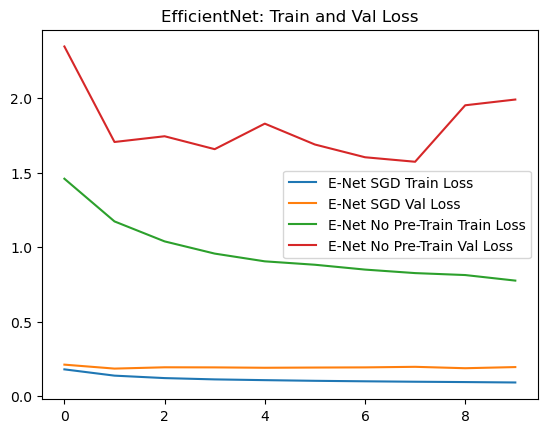

In [21]:
plt.title("EfficientNet: Train and Val Loss")
plt.plot(enet_sgd_train_loss, label="E-Net SGD Train Loss")
plt.plot(enet_sgd_val_loss, label="E-Net SGD Val Loss")
plt.plot(enet_sgd_no_pretrain_train_loss, label="E-Net No Pre-Train Train Loss")
plt.plot(enet_sgd_no_pretrain_val_loss, label="E-Net No Pre-Train Val Loss")
plt.legend()

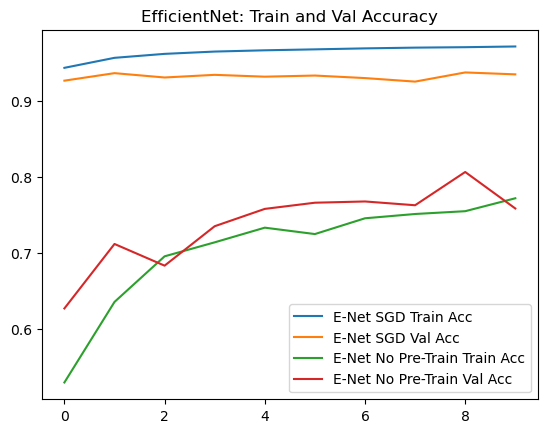

In [22]:
plt.title("EfficientNet: Train and Val Accuracy")
plt.plot(enet_sgd_train_acc, label="E-Net SGD Train Acc")
plt.plot(enet_sgd_val_acc, label="E-Net SGD Val Acc")
plt.plot(enet_sgd_no_pretrain_train_acc, label="E-Net No Pre-Train Train Acc")
plt.plot(enet_sgd_no_pretrain_val_acc, label="E-Net No Pre-Train Val Acc")
plt.legend()

### Per-Class ROC Curves

In [23]:
id_to_class_name = {0: 'Aortic enlargement',
                    1: 'Atelectasis',
                    2: 'Calcification',
                    3: 'Cardiomegaly',
                    4: 'Consolidation',
                    5: 'ILD',
                    6: 'Infiltration',
                    7: 'Lung Opacity',
                    8: 'Nodule/Mass',
                    9: 'Other lesion',
                    10: 'Pleural effusion',
                    11: 'Pleural thickening',
                    12: 'Pneumothorax',
                    13: 'Pulmonary fibrosis',
                    14: 'No finding'}

In [24]:
def get_per_class_roc_curves(targets_list, preds_list):
    targets_list = targets_list.T
    preds_list = preds_list.T
    per_class_roc_curves = np.array([roc_curve(i,j) if len(set(i)) > 1 else np.nan for i,j in zip(targets_list, preds_list)])
    per_class_auc = np.array([roc_auc_score(i,j) if len(set(i)) > 1 else np.nan for i,j in zip(targets_list, preds_list)])
    
    return per_class_auc, per_class_roc_curves

In [25]:
per_class_auc, per_class_roc_curves = get_per_class_roc_curves(targets, preds)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


AUC score = 0.8785824068018313
AUC score = 0.8680547796523598
AUC score = 0.8522881748241985
AUC score = 0.9443560519964065
AUC score = 0.9362588957759411
AUC score = 0.8831947427294887
AUC score = 0.9294638880423827
AUC score = 0.8795030700894898
AUC score = 0.8805973152201906
AUC score = 0.8607979089484705
AUC score = 0.9803916065598308
AUC score = 0.880517683550045
AUC score = 0.9706759072956257
AUC score = 0.8787221958202451
AUC score = 0.9392693892670516


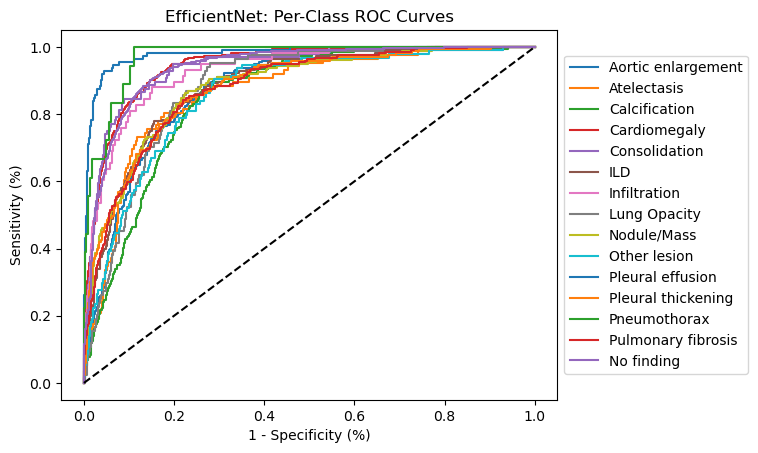

In [28]:
for i, ((fpr, tpr, thresholds), auc) in enumerate(zip(per_class_roc_curves, per_class_auc)):
    class_name = id_to_class_name[i]
    plt.plot(fpr, tpr, label=f"{class_name}")
    print(f"AUC score = {auc}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("EfficientNet: Per-Class ROC Curves")
plt.ylabel("Sensitivity (%)")
plt.xlabel("1 - Specificity (%)")
plt.legend()
plt.legend(bbox_to_anchor=(1.0, 0.95))
plt.savefig("per_class_roc_curves.png")